### Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Import from local directory
import sys
sys.path.insert(0, './fnn')
from models import LSTMEmbedding, MLPEmbedding
from regularizers import FNN

plt.rcParams['lines.linewidth'] = .1
plt.rcParams['axes.prop_cycle'] = plt.cycler(color="k") 

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Lorenz attractor

### Load and view dataset

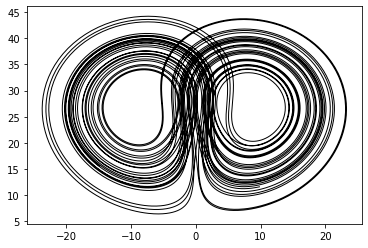

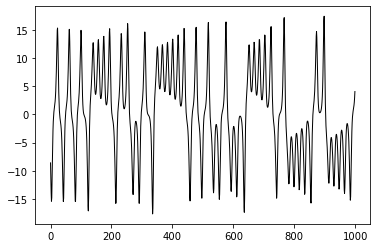

In [2]:
# Load an example dataset
sol = np.loadtxt("datasets/lorenz.csv.gz", delimiter=",")

# A one-dimensional downsampled observation
obs = sol[0][::10]

plt.figure()
plt.plot(sol[1][:10000], sol[2][:10000], linewidth=1)


plt.figure()
plt.plot(obs[:1000], linewidth=1)

### Create model and generate embedding

In [73]:
model = MLPEmbedding(10, 
                     time_window=5,
                     latent_regularizer=FNN(1),
                     random_state=0
                     )
coords = model.fit_transform(obs[:5010])

### Visualize the embedding

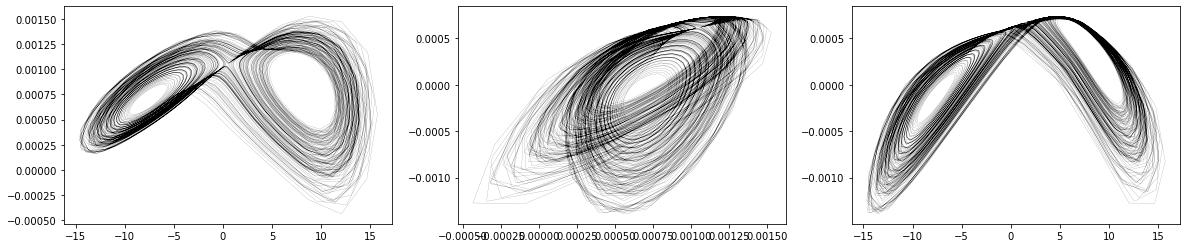

In [74]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
ax[0].plot(coords[:, 0], coords[:, 1])
ax[1].plot(coords[:, 1], coords[:, 2])
ax[2].plot(coords[:, 0], coords[:, 2])

In [75]:
# View interactive plot in 3D. Requires working mplot3d installation
%matplotlib widget
%matplotlib widget
%matplotlib widget

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection= '3d')
ax.plot(coords[:,0], coords[:,1], coords[:,2], color='k')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Double pendulum dataset

Experimental dataset from [Asseman et al 2019](https://developer.ibm.com/exchanges/data/all/double-pendulum-chaotic/) corresponding to centroid measurements of a chaotic double pendulum. $\dot\theta_1$ (the angular velocity of the second coordinate) is extracted and used for fitting the model

#### Import dataset

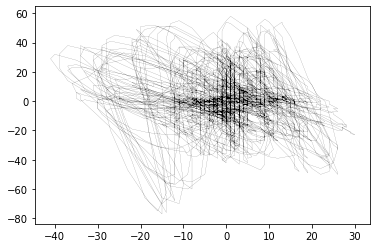

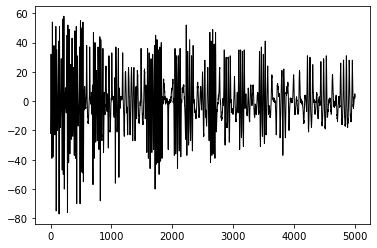

In [77]:
sol = np.loadtxt('datasets/pendulum_train.csv.gz', delimiter=',')
obs = sol[3]

%matplotlib inline

plt.figure()
plt.plot(sol[2, :], sol[3, :])

plt.figure()
plt.plot(obs[:5000], linewidth=1)

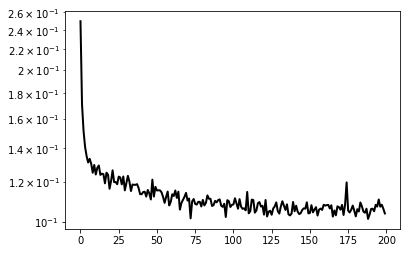

<Figure size 432x288 with 0 Axes>

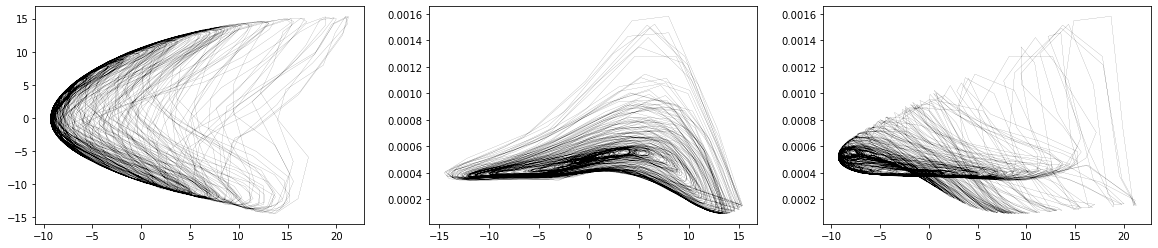

In [89]:
model = LSTMEmbedding(10, 
                     time_window=5, 
                     latent_regularizer=FNN(1e-1), 
                     random_state=0
                     )
coords = model.fit_transform(obs, learning_rate=1e-2)

%matplotlib inline

plt.figure()
plt.semilogy(model.train_history.history["loss"], linewidth=2)

plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords[:, 0], coords[:, 1])
ax[1].plot(coords[:, 1], coords[:, 2])
ax[2].plot(coords[:, 0], coords[:, 2])

In [90]:
# View interactive plot in 3D. Requires working mplot3d installation
%matplotlib widget
%matplotlib widget
%matplotlib widget

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection= '3d')
ax.plot(coords[:,0], coords[:,1], coords[:,2], color='k')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Torus dataset

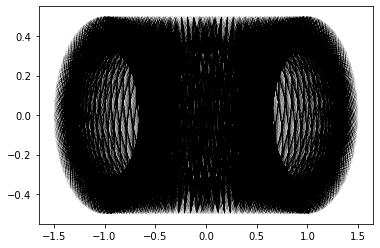

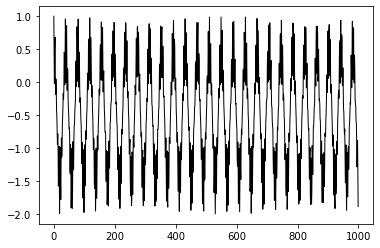

In [91]:
sol = np.loadtxt('datasets/torus.csv.gz', delimiter=',')
obs = sol[0]

%matplotlib inline 

plt.figure()
plt.plot(sol[1][:10000], sol[2][:10000])

plt.figure()
plt.plot(obs[:1000], linewidth=1)

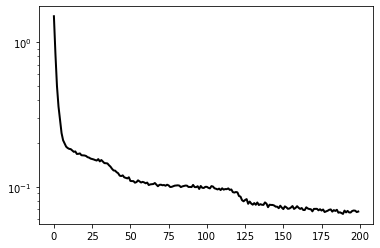

<Figure size 432x288 with 0 Axes>

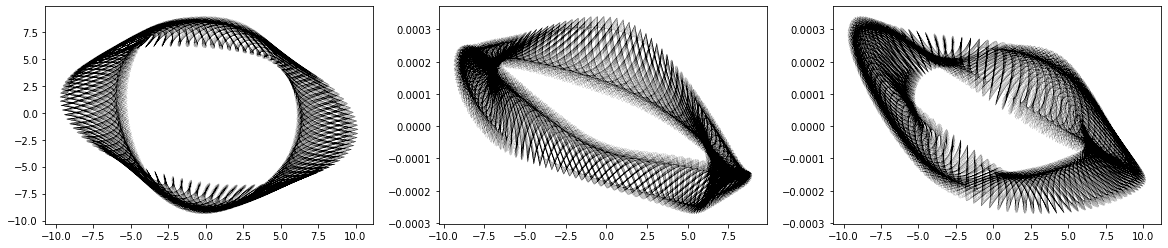

In [105]:
model = MLPEmbedding(10, 
                     time_window=20,
                     latent_regularizer=FNN(1e-1),
                     random_state=0
                     )
coords = model.fit_transform(obs[:5000])

%matplotlib inline

plt.figure()
plt.semilogy(model.train_history.history["loss"], linewidth=2)


plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords[:, 0], coords[:, 1])
ax[1].plot(coords[:, 1], coords[:, 2])
ax[2].plot(coords[:, 0], coords[:, 2])

In [106]:
# View interactive plot in 3D. Requires working mplot3d installation
%matplotlib widget

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection= '3d')
ax.plot(coords[:,0], coords[:,1], coords[:,2], color='k')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Rössler

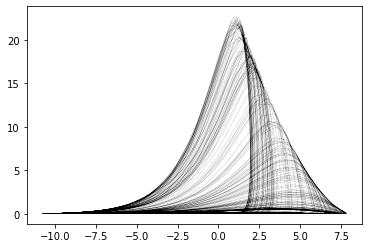

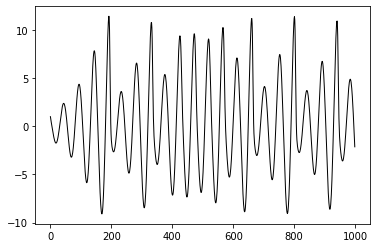

In [106]:
sol = np.loadtxt('datasets/rossler.csv.gz', delimiter=',')
obs = sol[0]

%matplotlib inline

plt.figure()
plt.plot(sol[1][:10000], sol[2][:10000])

plt.figure()
plt.plot(obs[:1000], linewidth=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


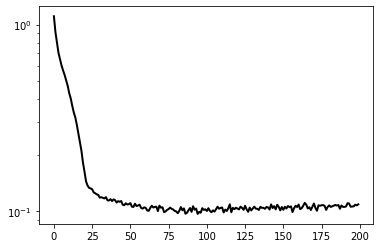

<Figure size 432x288 with 0 Axes>

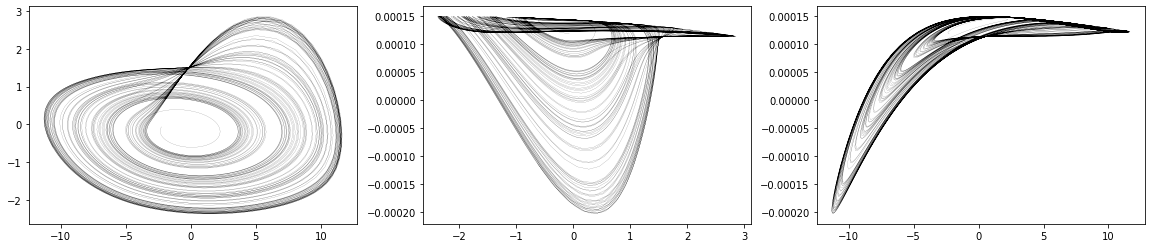

In [109]:
model = LSTMEmbedding(10, 
                     time_window=10,
                     latent_regularizer=FNN(1e1),
                     random_state=0
                     )
coords = model.fit_transform(obs[:5000], learning_rate=1e-3)

%matplotlib inline

plt.figure()
plt.semilogy(model.train_history.history["loss"], linewidth=2)

plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords[:, 0], coords[:, 1])
ax[1].plot(coords[:, 1], coords[:, 2])
ax[2].plot(coords[:, 0], coords[:, 2])

In [105]:
# View interactive plot in 3D. Requires working mplot3d installation
%matplotlib widget

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection= '3d')
ax.plot(coords[:,0], coords[:,1], coords[:,2], color='k')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Ecosystem model

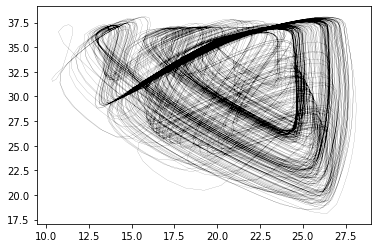

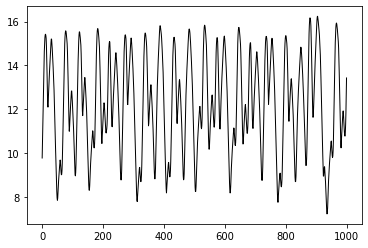

In [23]:
sol = np.loadtxt('datasets/ecosystem.csv.gz', delimiter=',')
obs = sol[0]

plt.figure()
plt.plot(sol[1][:10000], sol[2][:10000], 'k', linewidth=.1)

plt.figure()
plt.plot(obs[:1000], 'k', linewidth=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


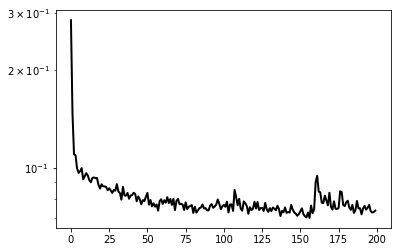

<Figure size 432x288 with 0 Axes>

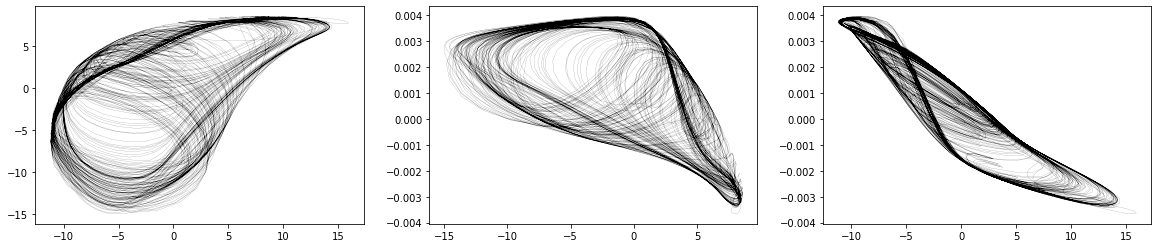

In [27]:
model = LSTMEmbedding(10, 
                     time_window=10,
                     latent_regularizer=FNN(1e-1),
                     random_state=0
                     )
coords = model.fit_transform(obs[:5000], learning_rate=1e-2)

%matplotlib inline

plt.figure()
plt.semilogy(model.train_history.history["loss"], linewidth=2)

plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords[:, 0], coords[:, 1])
ax[1].plot(coords[:, 1], coords[:, 2])
ax[2].plot(coords[:, 0], coords[:, 2])

In [28]:
# View interactive plot in 3D. Requires working mplot3d installation
%matplotlib widget
%matplotlib widget
%matplotlib widget

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection= '3d')
ax.plot(coords[:,0], coords[:,1], coords[:,2], color='k')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Embed a multivariate time series

We show an example of embedding a multivariate time series dataset. The dataset should have shape $(T, D)$, and the number of dimensions $D$ should be explicitly passed to the model constructor as the `n_features` argument. Otherwise, the model construction and attributes are identical

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


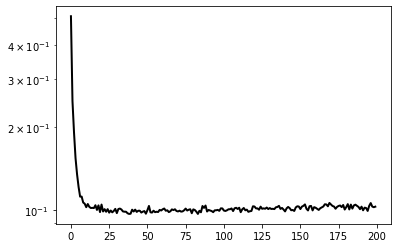

<Figure size 432x288 with 0 Axes>

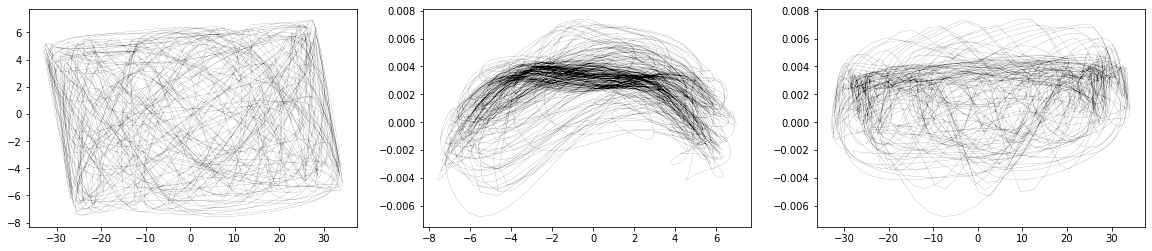

In [337]:
# Load dataset and select observation
sol = np.loadtxt('datasets/pendulum_train.csv.gz', delimiter=',')
obs = sol[:2, :].T

# Construct model, note the n_features argument
model = MLPEmbedding(10, 
                     time_window=10, 
                     latent_regularizer=FNN(1.0), 
                     random_state=0,
                     n_features=2
                     )
# Fit and apply embedding
coords = model.fit_transform(obs, learning_rate=1e-2)

# Plot embedding
%matplotlib inline
plt.figure()
plt.semilogy(model.train_history.history["loss"], linewidth=2)

plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords[:, 0], coords[:, 1])
ax[1].plot(coords[:, 1], coords[:, 2])
ax[2].plot(coords[:, 0], coords[:, 2])

In [339]:
# View interactive plot in 3D. Requires working mplot3d installation
%matplotlib widget
%matplotlib widget
%matplotlib widget

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection= '3d')
ax.plot(coords[:,0], coords[:,1], coords[:,2], color='k')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …